# MIMO OFDM Transmissions over the CDL Channel Model

My first objective here is simulate a transmission with Zero forcing applied on dowlink step to optmizate the communication and setup a monte-carlo simulation for a MIMO-OFDM system.

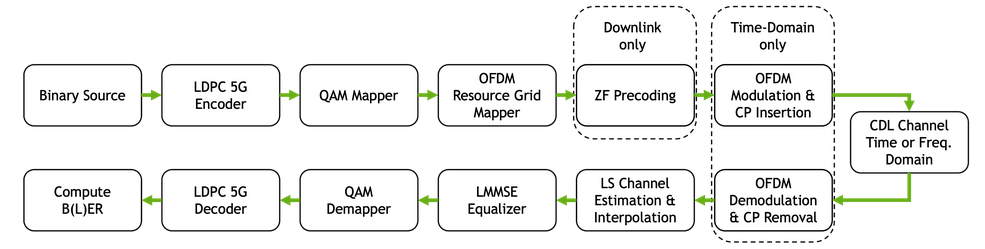

The setup includes:

+ 5G LDPC FEC
+ QAM modulation
+ OFDM resource grid with configurabel pilot pattern
+ Multiple data streams
+ 3GPP 38.901 CDL channel models and antenna patterns
+ ZF Precoding with perfect channel state information
+ LS Channel estimation with nearest-neighbor interpolation as well as perfect CSI
+ LMMSE MIMO equalization



In [2]:


# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)


Number of GPUs available : 0


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber

In [4]:


# Define the number of UT and BS antennas.
# For the CDL model, that will be used in this notebook, only
# a single UT and BS are supported.
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)



## Antenna Arrays


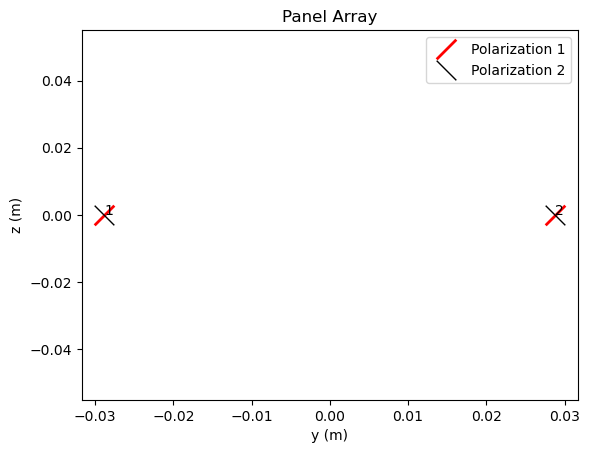

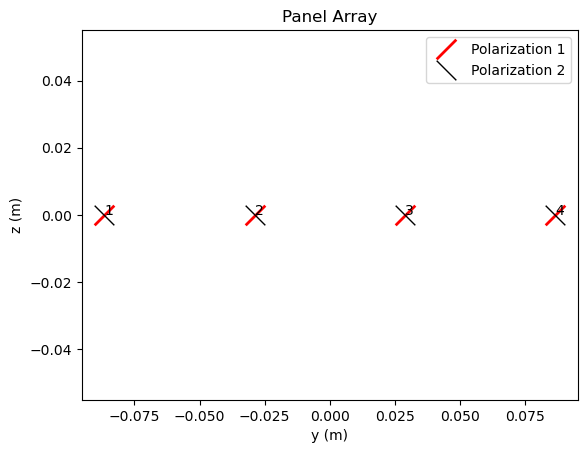

In [8]:
carrier_frequency = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
bs_array.show()

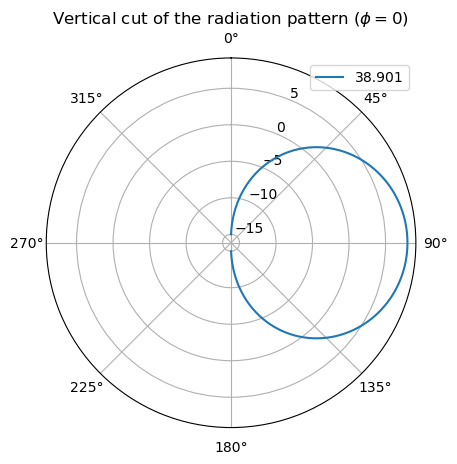

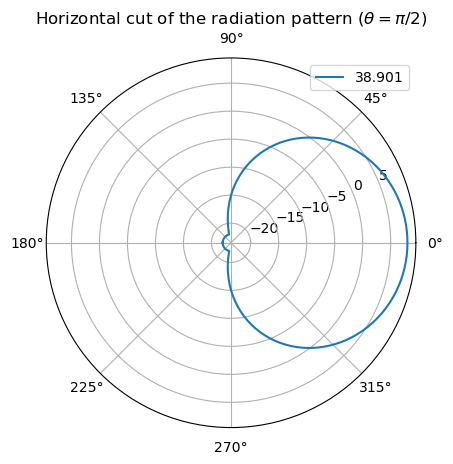

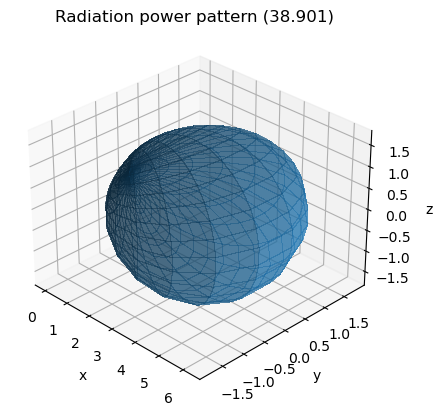

In [34]:
ut_array.show_element_radiation_pattern()

## CDL Channel Model

In [11]:
delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value. 

direction = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "B"       # Suitable values are ["A", "B", "C", "D", "E"]

speed = 10            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)
a, tau = cdl(batch_size=32, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)


Shape of the path gains:  (32, 1, 8, 1, 4, 23, 14)
Shape of the delays: (32, 1, 1, 23)


In [13]:
"""


plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


plt.figure()
plt.title("Time evolution of path gain")
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])

plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

"""



'\n\n\nplt.figure()\nplt.title("Channel impulse response realization")\nplt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])\nplt.xlabel(r"$\tau$ [ns]")\nplt.ylabel(r"$|a|$")\n\n\nplt.figure()\nplt.title("Time evolution of path gain")\nplt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])\nplt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])\nplt.legend(["Real part", "Imaginary part"])\n\nplt.xlabel(r"$t$ [us]")\nplt.ylabel(r"$a$");\n\n'

In [14]:
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

In [15]:
"""


plt.figure()
plt.title("Channel frequency response")
plt.plot(np.real(h_freq[0,0,0,0,0,0,:]))
plt.plot(np.imag(h_freq[0,0,0,0,0,0,:]))
plt.xlabel("OFDM Symbol Index")
plt.ylabel(r"$h$")
plt.legend(["Real part", "Imaginary part"]);

"""

'\n\n\nplt.figure()\nplt.title("Channel frequency response")\nplt.plot(np.real(h_freq[0,0,0,0,0,0,:]))\nplt.plot(np.imag(h_freq[0,0,0,0,0,0,:]))\nplt.xlabel("OFDM Symbol Index")\nplt.ylabel(r"$h$")\nplt.legend(["Real part", "Imaginary part"]);\n\n'

In [20]:
# Function that will apply the channel frequency response to an input signal
channel_freq = ApplyOFDMChannel(add_awgn=True)


# The following values for truncation are recommended.
# Please feel free to tailor them to you needs.
l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
l_tot = l_max-l_min+1

a, tau = cdl(batch_size=2, num_time_steps=rg.num_time_samples+l_tot-1, sampling_frequency=rg.bandwidth)

h_time = cir_to_time_channel(rg.bandwidth, a, tau, l_min=l_min, l_max=l_max, normalize=True)
channel_time = ApplyTimeChannel(rg.num_time_samples, l_tot=l_tot, add_awgn=True)


In [21]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, l_min, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

## Simulation step


In [23]:
batch_size = 32 # Depending on the memory of your GPU (or system when a CPU is used),
                # you can in(de)crease the batch size. The larger the batch size, the
                # more memory is required. However, simulations will also run much faster.
ebno_db = 40
perfect_csi = False # Change to switch between perfect and imperfect CSI

# Compute the noise power for a given Eb/No value.
# This takes not only the coderate but also the overheads related pilot
# transmissions and nulled carriers
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# As explained above, we generate random batches of CIR, transform them
# in the frequency domain and apply them to the resource grid in the
# frequency domain.
cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
y = channel_freq([x_rg, h_freq, no])

if perfect_csi:
    # For perfect CSI, the receiver gets the channel frequency response as input
    # However, the channel estimator only computes estimates on the non-nulled
    # subcarriers. Therefore, we need to remove them here from `h_freq`.
    # This step can be skipped if no subcarriers are nulled. 
    h_hat, err_var = remove_nulled_scs(h_freq), 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

ofdm_channel = OFDMChannel(cdl, rg, add_awgn=True, normalize_channel=True, return_channel=True)
y, h_freq = ofdm_channel([x_rg, no])



BER: 0.0


In [25]:
# Uplink transmission in time domain

batch_size = 4 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
ebno_db = 30
perfect_csi = True

no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# The CIR needs to be sampled every 1/bandwith [s].
# In contrast to frequency-domain modeling, this implies
# that the channel can change over the duration of a single
# OFDM symbol. We now also need to simulate more
# time steps.
cir = cdl(batch_size, rg.num_time_samples+l_tot-1, rg.bandwidth)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)

# Compute the discrete-time channel impulse reponse
h_time = cir_to_time_channel(rg.bandwidth, *cir, l_min, l_max, normalize=True)

# Compute the channel output
# This computes the full convolution between the time-varying
# discrete-time channel impulse reponse and the discrete-time
# transmit signal. With this technique, the effects of an
# insufficiently long cyclic prefix will become visible. This
# is in contrast to frequency-domain modeling which imposes
# no inter-symbol interfernce.
y_time = channel_time([x_time, h_time, no])

# OFDM demodulation and cyclic prefix removal
y = demodulator(y_time)

if perfect_csi:
    
    a, tau = cir
    
    # We need to sub-sample the channel impulse reponse to compute perfect CSI
    # for the receiver as it only needs one channel realization per OFDM symbol
    a_freq = a[...,rg.cyclic_prefix_length:-1:(rg.fft_size+rg.cyclic_prefix_length)]
    a_freq = a_freq[...,:rg.num_ofdm_symbols]
    
    # Compute the channel frequency response
    h_freq = cir_to_ofdm_channel(frequencies, a_freq, tau, normalize=True)
   
    h_hat, err_var = remove_nulled_scs(h_freq), 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))

BER: 0.0


In [26]:


time_channel = TimeChannel(cdl, rg.bandwidth, rg.num_time_samples,
                           l_min=l_min, l_max=l_max, normalize_channel=True,
                           add_awgn=True, return_channel=True)

y_time, h_time = time_channel([x_time, no])



In [27]:


# In the example above, we assumed perfect CSI, i.e.,
# h_hat correpsond to the exact ideal channel frequency response.
h_perf = h_hat[0,0,0,0,0,0]

# We now compute the LS channel estimate from the pilots.
h_est, _ = ls_est ([y, no])
h_est = h_est[0,0,0,0,0,0]



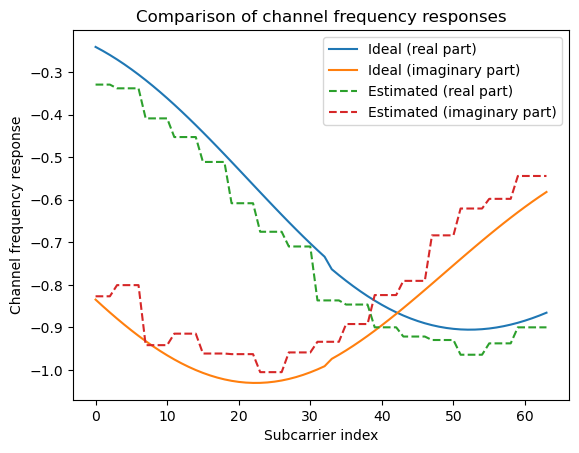

In [28]:


plt.figure()
plt.plot(np.real(h_perf))
plt.plot(np.imag(h_perf))
plt.plot(np.real(h_est), "--")
plt.plot(np.imag(h_est), "--")
plt.xlabel("Subcarrier index")
plt.ylabel("Channel frequency response")
plt.legend(["Ideal (real part)", "Ideal (imaginary part)", "Estimated (real part)", "Estimated (imaginary part)"]);
plt.title("Comparison of channel frequency responses");



In [30]:
# Downlink transmission in frequency domain




direction = "downlink"
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)


perfect_csi = True # Change to switch between perfect and imperfect CSI
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)

b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)
cir = cdl(batch_size, rg.num_ofdm_symbols, 1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, *cir, normalize=True)

# Precode the transmit signal in the frequency domain
# It is here assumed that the transmitter has perfect knowledge of the channel
# One could here reduce this to perfect knowledge of the channel for the first
# OFDM symbol, or a noisy version of it to take outdated transmit CSI into account.
# `g` is the post-beamforming or `effective channel` that can be
# used to simulate perfect CSI at the receiver.
x_rg, g = zf_precoder([x_rg, h_freq])

y = channel_freq([x_rg, h_freq, no])

if perfect_csi:
    # The receiver gets here the effective channel after precoding as CSI
    h_hat, err_var = g, 0.
else:
    h_hat, err_var = ls_est ([y, no])

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)
print("BER: {}".format(ber))


BER: 0.0


2023-03-01 18:02:36.559580: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 894976000 exceeds 10% of free system memory.
2023-03-01 18:02:41.632500: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 894976000 exceeds 10% of free system memory.
2023-03-01 18:02:47.027656: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 933888000 exceeds 10% of free system memory.


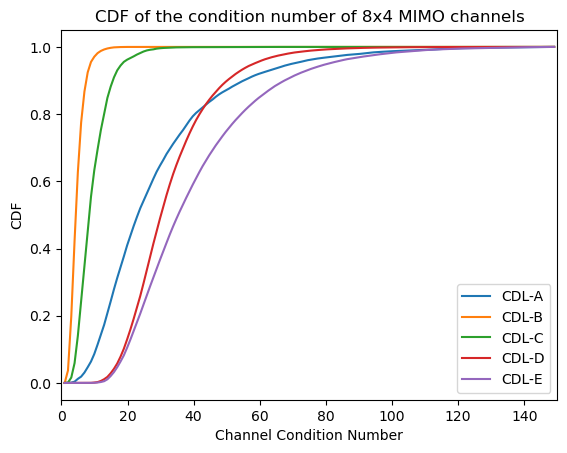

In [31]:
# Understanding the difference between the CDL models:



def fun(cdl_model):
    """Generates a histogram of the channel condition numbers"""
    
    # Setup a CIR generator
    cdl = CDL(cdl_model, delay_spread, carrier_frequency,
              ut_array, bs_array, "uplink", min_speed=0)
    
    # Generate random CIR realizations
    # As we nned only a single sample in time, the sampling_frequency
    # does not matter.
    cir = cdl(2000, 1, 1)
    
    # Compute the frequency response
    h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    
    # Reshape to [batch_size, fft_size, num_rx_ant, num_tx_ant]
    h = tf.squeeze(h)
    h = tf.transpose(h, [0,3,1,2])
    
    # Compute condition number
    c = np.reshape(np.linalg.cond(h), [-1])
    
    # Compute normalized histogram
    hist, bins = np.histogram(c, 150, (1, 150))
    hist = hist/np.sum(hist)
    return bins[:-1], hist

plt.figure()
for cdl_model in ["A", "B", "C", "D", "E"]:
    bins, hist = fun(cdl_model)
    plt.plot(bins, np.cumsum(hist))
plt.xlim([0,150])
plt.legend(["CDL-A", "CDL-B", "CDL-C", "CDL-D", "CDL-E"]);
plt.xlabel("Channel Condition Number")
plt.ylabel("CDF")
plt.title("CDF of the condition number of 8x4 MIMO channels");



In [32]:
# Final keras model



# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True. 
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    """This Keras model simulates OFDM MIMO transmissions over the CDL model.
    
    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.
    
    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.
        
    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.
        
    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.
        
    delay_spread : float
        The nominal delay spread [s].
        
    perfect_csi : bool
        Indicates if perfect CSI at the receiver should be assumed. For downlink
        transmissions, the transmitter is always assumed to have perfect CSI.
      
    speed : float
        The UT speed [m/s].
        
    cyclic_prefix_length : int
        The length of the cyclic prefix in number of samples.
        
    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.
        
    subcarrier_spacing : float
        The subcarrier spacing [Hz]. Defaults to 15e3. 
      
    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.
        
    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.
        
    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.
        
    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.   
    """
    
    def __init__(self,
                 domain,
                 direction,
                 cdl_model,
                 delay_spread,
                 perfect_csi,
                 speed,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 15e3 
                ):
        super().__init__()
        
        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        
        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 8 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2 
        self._coderate = 0.5
          
        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)
        
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices) 
        
        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate) 
        
        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)
        
        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)
        
        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)
        
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        
        if self._domain == "freq":  
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)
               
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        
        if self._direction == "downlink":
            self._zf_precoder = ZFPrecoder(self._rg, self._sm, return_effective_channel=True)
       
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function(jit_compile=True) # See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):
        
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
                  
        if self._domain == "time":
            # Time-domain simulations
            
            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)
            
            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            x_time = self._modulator(x_rg)
            y_time = self._channel_time([x_time, h_time, no])
            
            y = self._demodulator(y_time)
            
        elif self._domain == "freq":
            # Frequency-domain simulations
            
            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            y = self._channel_freq([x_rg, h_freq, no])
        
        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0            
        else:
            h_hat, err_var = self._ls_est ([y, no])
        
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)
            
        return b, b_hat



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-01 18:04:11.671554: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xe40bf40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-01 18:04:11.671576: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-03-01 18:04:11.949358: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. binary_source_3/random_uniform
2023-03-01 18:04:11.963570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-01 18:04:12.064161: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator ldpc5g_encoder_1/assert_equal_1/Assert/AssertGuard/Assert
2023-03-01 18:04:12.093326: W tensorflow/compiler/tf2xla/

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------


2023-03-01 18:04:34.963803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1585447872 exceeds 10% of free system memory.


     -5.0 | 1.2059e-01 | 5.8594e-01 |      177822 |     1474560 |         1200 |        2048 |        32.4 |reached target block errors
     -1.0 | 5.8501e-02 | 3.1982e-01 |      172527 |     2949120 |         1310 |        4096 |        12.3 |reached target block errors
      3.0 | 2.0112e-02 | 1.2488e-01 |      118625 |     5898240 |         1023 |        8192 |        24.2 |reached target block errors
      7.0 | 4.9030e-03 | 3.2813e-02 |      108446 |    22118400 |         1008 |       30720 |        89.4 |reached target block errors
     11.0 | 9.0889e-04 | 6.5918e-03 |       67011 |    73728000 |          675 |      102400 |       301.7 |reached max iter       
     15.0 | 1.3738e-04 | 1.0645e-03 |       10129 |    73728000 |          109 |      102400 |       301.8 |reached max iter       
     19.0 | 2.3098e-05 | 1.6602e-04 |        1703 |    73728000 |           17 |      102400 |       297.8 |reached max iter       


2023-03-01 18:21:50.875163: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-01 18:22:04.084117: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15.209054005s
Constant folding an instruction is taking > 2s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inher

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.3829e-03 | 4.4656e-02 |      103531 |    16220160 |         1006 |       22528 |        87.8 |reached target block errors
     -1.0 | 2.6708e-04 | 2.1094e-03 |       19691 |    73728000 |          216 |      102400 |       303.0 |reached max iter       
      3.0 | 3.0111e-06 | 5.8594e-05 |         222 |    73728000 |            6 |      102400 |       320.7 |reached max iter       
      7.0 | 0.0000e+00 | 0.0000e+00 |           0 |    73728000 |            0 |      102400 |       309.9 |reached max iter       

Simulation stopped as no error occurred @ EbNo = 7.0 dB.



2023-03-01 18:38:54.692439: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-01 18:39:05.852517: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15.160180995s
Constant folding an instruction is taking > 4s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inher

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.9274e-02 | 2.2832e-01 |      144778 |     3686400 |         1169 |        5120 |        37.2 |reached target block errors
     -1.0 | 7.3585e-03 | 4.8596e-02 |      113931 |    15482880 |         1045 |       21504 |        63.2 |reached target block errors
      3.0 | 8.1668e-04 | 5.8887e-03 |       60212 |    73728000 |          603 |      102400 |       301.9 |reached max iter       
      7.0 | 5.6207e-05 | 4.3945e-04 |        4144 |    73728000 |           45 |      102400 |       300.2 |reached max iter       
     11.0 | 1.9803e-06 | 1.9531e-05 |         146 |    73728000 |            2 |      102400 |       297.6 |reached max iter       
     15.0 | 0.0000e+00 | 0.0000e+00 |           0 |    73728000 |            

2023-03-01 19:00:34.633040: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-01 19:00:41.661804: E tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 15.028853073s
Constant folding an instruction is taking > 8s:

  reduce.5030 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inher

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.1519e-01 | 9.6045e-01 |      317306 |     1474560 |         1967 |        2048 |        27.5 |reached target block errors
     -1.0 | 1.1513e-01 | 6.8555e-01 |      169773 |     1474560 |         1404 |        2048 |         5.5 |reached target block errors
      3.0 | 2.4420e-02 | 2.0059e-01 |       90023 |     3686400 |         1027 |        5120 |        14.2 |reached target block errors
      7.0 | 1.5893e-03 | 1.6618e-02 |       69134 |    43499520 |         1004 |       60416 |       165.1 |reached target block errors
     11.0 | 3.2647e-05 | 3.9063e-04 |        2407 |    73728000 |           40 |      102400 |       281.0 |reached max iter       
     15.0 | 8.5449e-07 | 1.9531e-05 |          63 |    73728000 |    

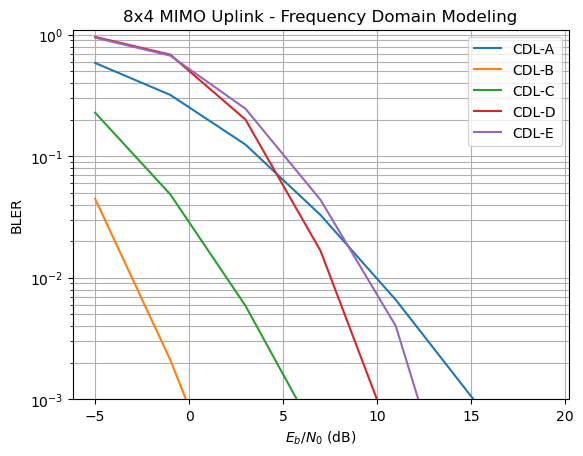

In [33]:
UL_SIMS = {
    "ebno_db" : list(np.arange(-5, 20, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "uplink",
    "perfect_csi" : True,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for cdl_model in UL_SIMS["cdl_model"]:
    
    model = Model(domain=UL_SIMS["domain"],
                  direction=UL_SIMS["direction"],
                  cdl_model=cdl_model,
                  delay_spread=UL_SIMS["delay_spread"],
                  perfect_csi=UL_SIMS["perfect_csi"],
                  speed=UL_SIMS["speed"],
                  cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])
    
    ber, bler = sim_ber(model,
                        UL_SIMS["ebno_db"],
                        batch_size=256,
                        max_mc_iter=100,
                        num_target_block_errors=1000)
    
    UL_SIMS["ber"].append(list(ber.numpy()))
    UL_SIMS["bler"].append(list(bler.numpy()))

UL_SIMS["duration"] = time.time() - start


# Compare Uplink Performance Over the Different CDL Models 

# Load results (un comment to show saved results from the cell above)
#UL_SIMS = eval(" {'ebno_db': [-5.0, -1.0, 3.0, 7.0, 11.0, 15.0, 19.0], 'cdl_model': ['A', 'B', 'C', 'D', 'E'], 'delay_spread': 1e-07, 'domain': 'freq', 'direction': 'uplink', 'perfect_csi': True, 'speed': 0.0, 'cyclic_prefix_length': 6, 'pilot_ofdm_symbol_indices': [2, 11], 'ber': [[0.15734931098090277, 0.08457483362268518, 0.037556287977430554, 0.010201009114583333, 0.0021562364366319443, 0.0004007025824652778, 3.371853298611111e-05], [0.00840893126370614, 0.0004711371527777778, 6.686740451388889e-06, 0.0, 0.0, 0.0, 0.0], [0.05171542697482639, 0.010815988179125817, 0.0012970784505208334, 7.362196180555556e-05, 2.292209201388889e-06, 2.4142795138888887e-06, 0.0], [0.2598809136284722, 0.19302435980902777, 0.07624737774884259, 0.01058502197265625, 0.0003685031467013889, 2.102322048611111e-06, 0.0], [0.25929497612847224, 0.1982150607638889, 0.08891149450231481, 0.021271128713348766, 0.002695751694775132, 0.00017363823784722222, 5.126953125e-06]], 'bler': [[0.65869140625, 0.3756510416666667, 0.18131510416666666, 0.05242598684210526, 0.011625744047619048, 0.00220703125, 0.00017578125], [0.05396792763157895, 0.0032421875, 7.8125e-05, 0.0, 0.0, 0.0, 0.0], [0.26513671875, 0.05962775735294118, 0.007724609375, 0.0005078125, 9.765625e-06, 9.765625e-06, 0.0], [0.986328125, 0.84765625, 0.390625, 0.06243896484375, 0.00248046875, 1.953125e-05, 0.0], [0.98046875, 0.8515625, 0.4348958333333333, 0.115234375, 0.015562996031746032, 0.001083984375, 2.9296875e-05]], 'duration': 679.6544234752655} ")

print("Simulation duration: {:1.2f} [h]".format(UL_SIMS["duration"]/3600))

plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.title("8x4 MIMO Uplink - Frequency Domain Modeling");
plt.ylim([1e-3, 1.1])
legend = []
for i, bler in enumerate(UL_SIMS["bler"]):
    plt.semilogy(UL_SIMS["ebno_db"], bler)
    legend.append("CDL-{}".format(UL_SIMS["cdl_model"][i]))
plt.legend(legend);
